In [63]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import sklearn

# from pandas import Series, DataFrame
from pylab import rcParams
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics 
from sklearn.metrics import classification_report
from tableone import TableOne
import psutil
import requests

%matplotlib inline
rcParams['figure.figsize'] = 10, 8
sb.set_style('whitegrid')

import warnings
warnings.filterwarnings('ignore')

In [64]:
L4_Q4 = pd.read_csv("alldbs.csv", sep=',', encoding='ISO-8859-1')

In [65]:
print("Entre todas las bases de datos tenemos:")
print("Tenemos "+ str(len(L4_Q4))+" pacientes con "+str(len(list(L4_Q4.columns)))+" variables." )

Entre todas las bases de datos tenemos:
Tenemos 4861 pacientes con 46 variables.


# Preparacion datasets.
***

- Elimino intermedios
- Elimino columnas no importantes

In [66]:

L4_Q4_2 = L4_Q4.drop(['patient_id','sis_q', 'lactate', 'lactate_offset','hospdis_status','hosp_los'
                            ,'sis','psychiatric','fluid_electrolyte'
                            ], axis=1)

# L4_Q4_2['hospdis_status_28d'] = np.where(L4_Q4_2['hospdis_status_28d']==1,'Dead','Alive')
variables = list(['peripheral_vascular','hypertension','diabetes','hypothyroidism','renal_failure','liver_disease','metastatic_cancer','rheumatoid_arthritis','coagulopathy','obesity','deficiency_anemias','chronic_pulmonary_disease','solid_cancer','chronic_neurologic_diseases','substance_abuse','heart_diseases'])
for var in variables:
    L4_Q4_2[var] = np.where(L4_Q4_2[var]==1,'Yes','No')
    



In [67]:
print("High y normal tenemos:")
print("Tenemos "+ str(len(L4_Q4_2))+" pacientes con "+str(len(list(L4_Q4_2.columns)))+" variables." )


High y normal tenemos:
Tenemos 4861 pacientes con 37 variables.


# Tabla división databases

Tabla entre databases: 


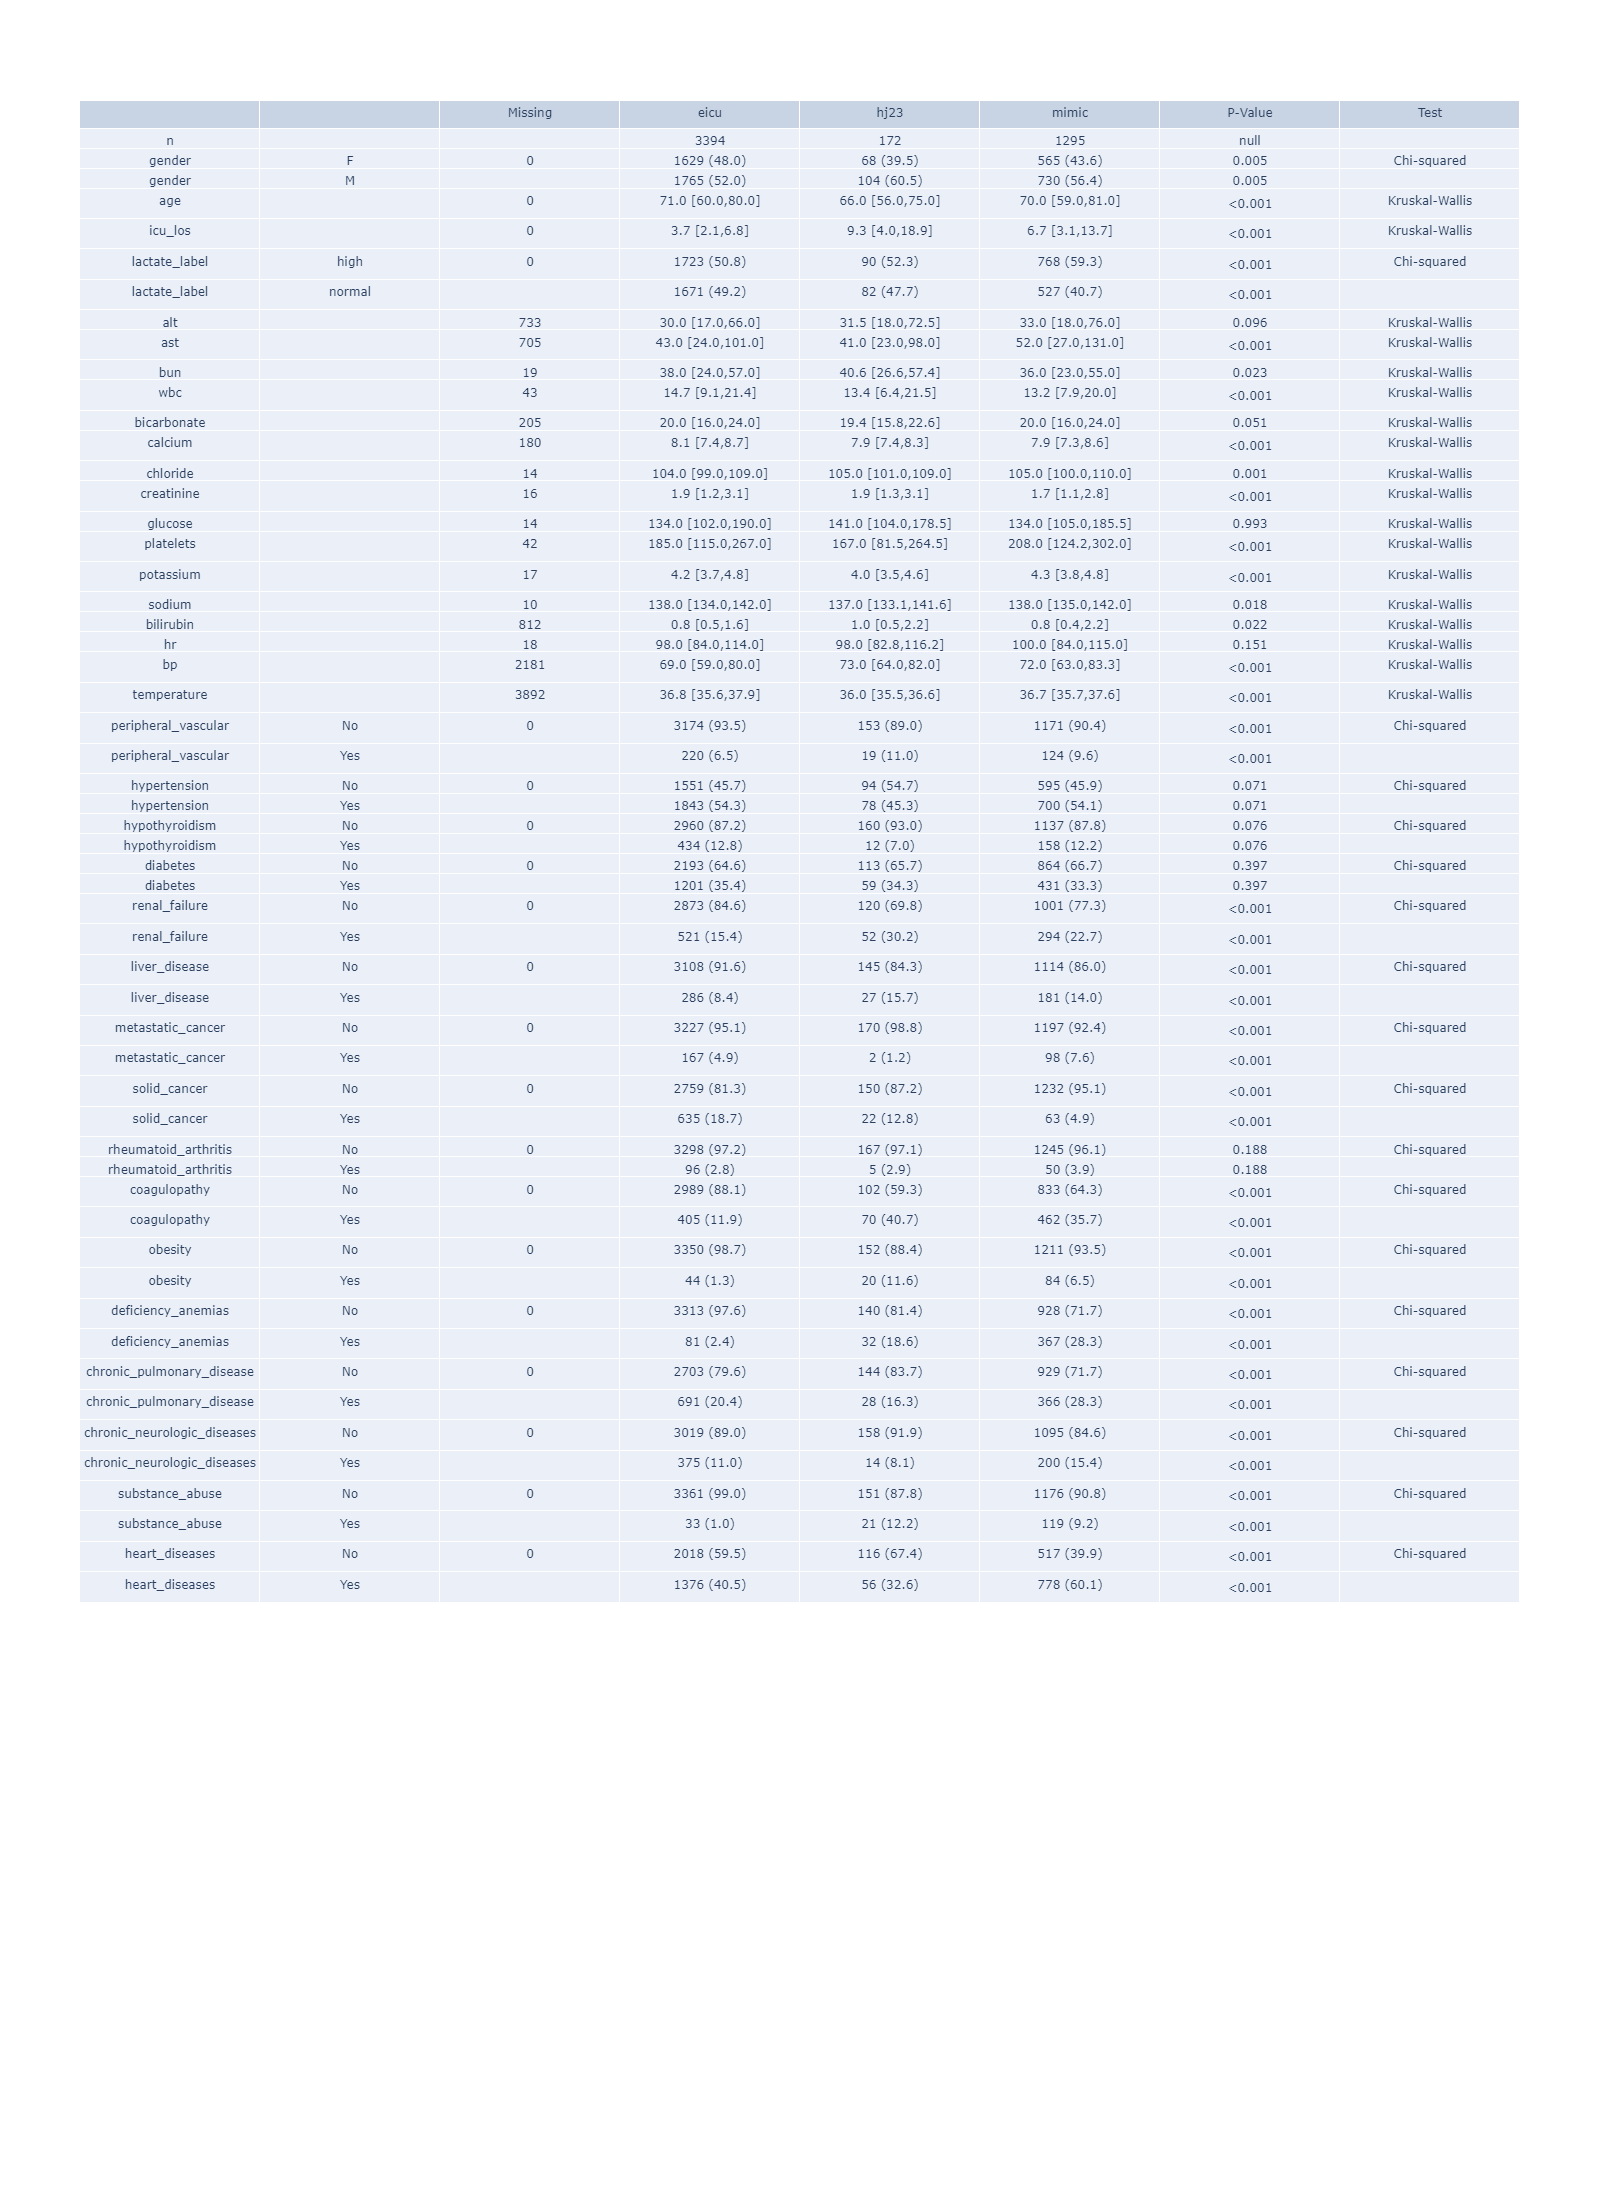

In [68]:
print("Tabla entre databases: ")
L4_Q4_2_db = L4_Q4_2.copy()


# TABLEONE para todo menos para ICU_LOS, IMV_d y VFD
# Divido las variables en categoricas y numéricas. 
categorical=list(L4_Q4_2_db.columns[L4_Q4_2_db.dtypes==np.object].drop('db'))
nonnormal=list(L4_Q4_2_db.columns[L4_Q4_2_db.dtypes!=np.object])

# Saco la tableone y formateo
tableOne=TableOne(L4_Q4_2_db, nonnormal=nonnormal,categorical=categorical,groupby=['db'], pval=True)
tableOne=tableOne.tableone.reset_index()
tableOne.columns = [col[0] if col[-1]=='' else col[-1] for col in tableOne.columns.values]
tableOne=tableOne.rename(columns={'level_0':'','level_1':' '})

tableOne.index= tableOne['']

# Elimino la columna de nulos porque no hay
# tableOne=tableOne.drop('Missing',axis=1)
tableOne['P-Value'] = np.where(tableOne['P-Value']=='',None,tableOne['P-Value'])
tableOne=tableOne.fillna(method='ffill')
# QuartilesScore=QuartilesScore.drop(columns={'Test'})

tableOne.to_csv('Tables/all_dbs.csv', sep=';', header = True, index=False)
# Ploteo la tabla
import plotly.graph_objects as go
fig = go.Figure(data=[go.Table(
    header=dict(values=list(tableOne.columns),
                align='center'),
    cells=dict(values=[tableOne[''],tableOne[' '],tableOne['Missing'],tableOne['eicu'],tableOne['hj23'],tableOne['mimic'],tableOne['P-Value'],tableOne['Test']],
               align='center'))
])
fig.update_layout(width=1600, height=2200)
# fig.write_image("Tables/all_dbs.png")

figura=fig.to_image(format='png')
from IPython.display import Image
display(Image(figura))


- Divido en databases

In [69]:
eicu = L4_Q4_2[L4_Q4_2['db']=='eicu']
eicu = eicu.reset_index(drop=True)
eicu = eicu.drop('db', axis=1)

eicu = eicu.drop(['icu_los'], axis=1)


In [70]:
print("En eicu tenemos: ")
print("Tenemos "+ str(len(eicu))+" pacientes con "+str(len(list(eicu.columns)))+" variables." )


En eicu tenemos: 
Tenemos 3394 pacientes con 35 variables.


# Detección de nulos e imputación.
***
**Hay que hacerlo para las 3 icus**

- Empiezo por eicu.

In [71]:
# Creo un dataframe donde tengo las variables y el número de nulos de cada variable y los ordeno.
Nulos_eicu=pd.DataFrame(eicu.isnull().sum()).rename(columns={0:'Nulos'}).sort_values(by='Nulos',ascending=False)
# Calculo el porcentaje de nulos
Nulos_eicu['PorcentajeNulos'] = Nulos_eicu['Nulos']/len(eicu)

print(Nulos_eicu.loc[Nulos_eicu['PorcentajeNulos']>0])

# Elimino las variables que tienen un 50% de nulos
DeleteNulos=list(Nulos_eicu.loc[Nulos_eicu['PorcentajeNulos']>0.5].index)
DeleteNulos.remove('temperature')
DeleteNulos.remove('bp')
eicu=eicu.drop(DeleteNulos, axis=1)

print("Voy a eliminar")
print(DeleteNulos)

#Muestro las dimensiones del nuevo dataframe
print("Tenemos "+ str(len(eicu))+" pacientes con "+str(len(list(eicu.columns)))+" variables." )






             Nulos  PorcentajeNulos
temperature   2757         0.812316
bp            2181         0.642605
bilirubin      567         0.167060
alt            513         0.151149
ast            486         0.143194
bicarbonate    202         0.059517
calcium         42         0.012375
wbc             42         0.012375
platelets       41         0.012080
hr              18         0.005303
potassium       17         0.005009
creatinine      15         0.004420
chloride        14         0.004125
glucose         13         0.003830
bun             11         0.003241
sodium          10         0.002946
Voy a eliminar
[]
Tenemos 3394 pacientes con 35 variables.


In [72]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# IteraiveImputer es capaz de simular los resultados de mice de R. Multivariate Imputation by Chained Equations
# Para imputar cada valor utiliza solo las 20 variables más cercanas.
imp = IterativeImputer(max_iter=10, random_state=0,initial_strategy='median',n_nearest_features=20)

# Solo se pueden imputar las numericas, por eso se separan las variables
categorical=eicu[list(eicu.columns[eicu.dtypes==np.object])]
categorical['index']=categorical.index
numerical=eicu[list(eicu.columns[eicu.dtypes!=np.object])]
numerical['index']=numerical.index

# Imputamos las variables numericas
numerical_imputed=imp.fit_transform(numerical)
numerical_imputed=pd.DataFrame(numerical_imputed, columns=numerical.columns)

# Unimos todas las variables
eicu=pd.merge(numerical_imputed,categorical, on=['index'],how='left')
eicu=eicu.drop('index',axis=1)


# Estandarización de los datos.
***

Podemos usar StandardScaler -> Media 0, desviación 1. A diferencias de creencias, no convierte la variable a una distribución normal.  
Podemos usar MinMaxScaler -> Valores entre 0 y 1. 

In [73]:
from sklearn.preprocessing import StandardScaler 
sc_eicu = StandardScaler() 


eicu_no_std = eicu.copy()



# eicu
categorical=eicu[list(eicu.columns[eicu.dtypes==np.object])]
categorical['index']=categorical.index
numerical=eicu[list(eicu.columns[eicu.dtypes!=np.object])]

# Estandarizacion de las variables numericas
numerical_std=sc_eicu.fit_transform(numerical)  
numerical_std=pd.DataFrame(numerical_std, columns=numerical.columns)
numerical_std['index']=numerical_std.index

# Unimos todas las variables
eicu=pd.merge(numerical_std,categorical, on=['index'],how='left')
eicu=eicu.drop('index',axis=1)



# Test de colinealidad.
***
Buscamos la colinealidad con un heatmap. 
La buscamos tanto en cada una de las bases de datos como en la conjunta.

- eicu


--------------------------
Colinealidad Inicial eicu


<AxesSubplot:>

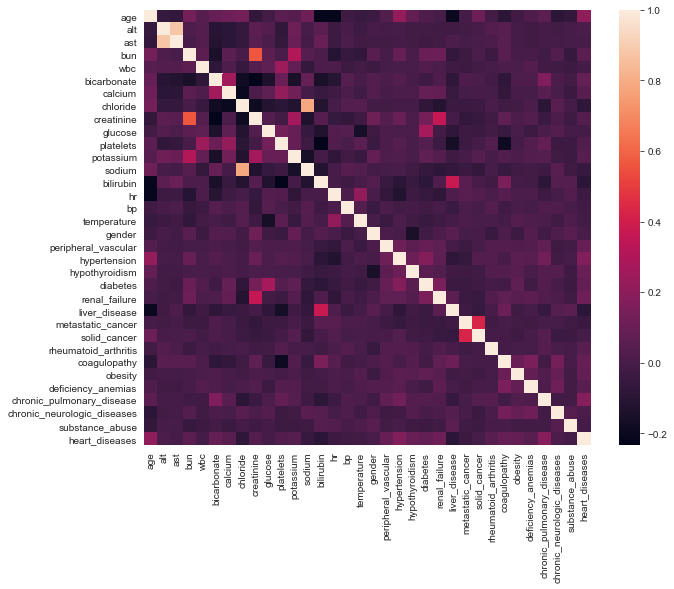

In [74]:
print("--------------------------")

print("Colinealidad Inicial eicu")

# %matplotlib inline
rcParams['figure.figsize'] = 10, 8
sb.set_style('whitegrid')

eicu_col = eicu.copy()

from sklearn import preprocessing
categorical=eicu_col[list(eicu_col.columns[eicu_col.dtypes==np.object])]
categorical=categorical.drop(['lactate_label'],axis=1)
for col in categorical:
    eicu_col[col] = preprocessing.LabelEncoder().fit_transform(eicu_col[col])
    
eicu_col = eicu_col.drop('lactate_label',axis=1)
                                                                                 
sb.heatmap(eicu_col.corr())


In [75]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = [variance_inflation_factor(eicu_col.values, eicu_col.columns.get_loc(var)) for var in eicu_col.columns]
print(pd.Series(vif,index=eicu_col.columns))


age                            1.313756
alt                            4.432629
ast                            4.423810
bun                            1.695567
wbc                            1.103483
bicarbonate                    1.610843
calcium                        1.256063
chloride                       4.060479
creatinine                     2.013358
glucose                        1.238178
platelets                      1.270903
potassium                      1.236343
sodium                         3.576614
bilirubin                      1.335852
hr                             1.164073
bp                             1.020202
temperature                    1.100317
gender                         1.690036
peripheral_vascular            1.113885
hypertension                   2.175143
hypothyroidism                 1.178575
diabetes                       1.705726
renal_failure                  1.454594
liver_disease                  1.314376
metastatic_cancer              1.309175


Hay correlación ast/alt, y sodium/chloride. Solo algo importante ast/alt.

Elimino alt y chloride por su Variance Inflation Factor tienen. 

In [76]:
eicu = eicu.drop(['alt'], axis=1)
eicu_col = eicu_col.drop(['alt'], axis=1)
eicu_no_std = eicu_no_std.drop(['alt'], axis=1)


Colinealidad Final eicu


<AxesSubplot:>

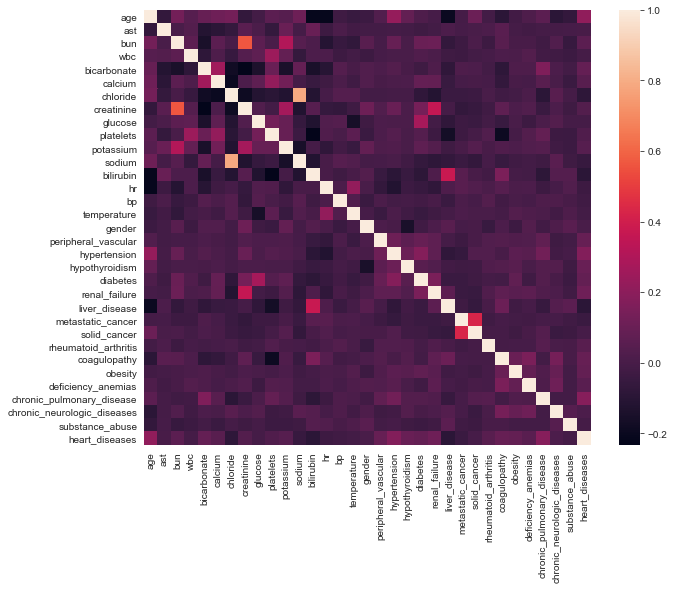

In [77]:
from sklearn import preprocessing
categorical=eicu_col[list(eicu_col.columns[eicu_col.dtypes==np.object])]
for col in categorical:
    eicu_col[col] = preprocessing.LabelEncoder().fit_transform(eicu_col[col])

print("Colinealidad Final eicu")
                                                                                 
sb.heatmap(eicu_col.corr())


In [78]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

## First var "MaxTvVol"
vif = [variance_inflation_factor(eicu_col.values, eicu_col.columns.get_loc(var)) for var in eicu_col.columns]
print(pd.Series(vif,index=eicu_col.columns))



age                            1.313677
ast                            1.080945
bun                            1.695562
wbc                            1.103360
bicarbonate                    1.610842
calcium                        1.253362
chloride                       4.052780
creatinine                     2.013023
glucose                        1.236751
platelets                      1.267361
potassium                      1.233781
sodium                         3.569020
bilirubin                      1.333959
hr                             1.163860
bp                             1.019761
temperature                    1.100126
gender                         1.688542
peripheral_vascular            1.113881
hypertension                   2.174922
hypothyroidism                 1.178557
diabetes                       1.705594
renal_failure                  1.453164
liver_disease                  1.310862
metastatic_cancer              1.308851
solid_cancer                   1.507747


Vemos que todavía puede haber una pequeña correlación en creatinine/bun, pero ambas son muy bajas. 

In [79]:
# guardo los datasets

eicu_for_importants = eicu.copy()
eicu_for_importants_no_std = eicu_no_std.copy()




# Selección de variables.
***
Hago una TableOne y de aquí obtengo los P-Values, los tests utilizados son ambos no paramétricos.

- eicu

--------------------------
Table lactate eicu


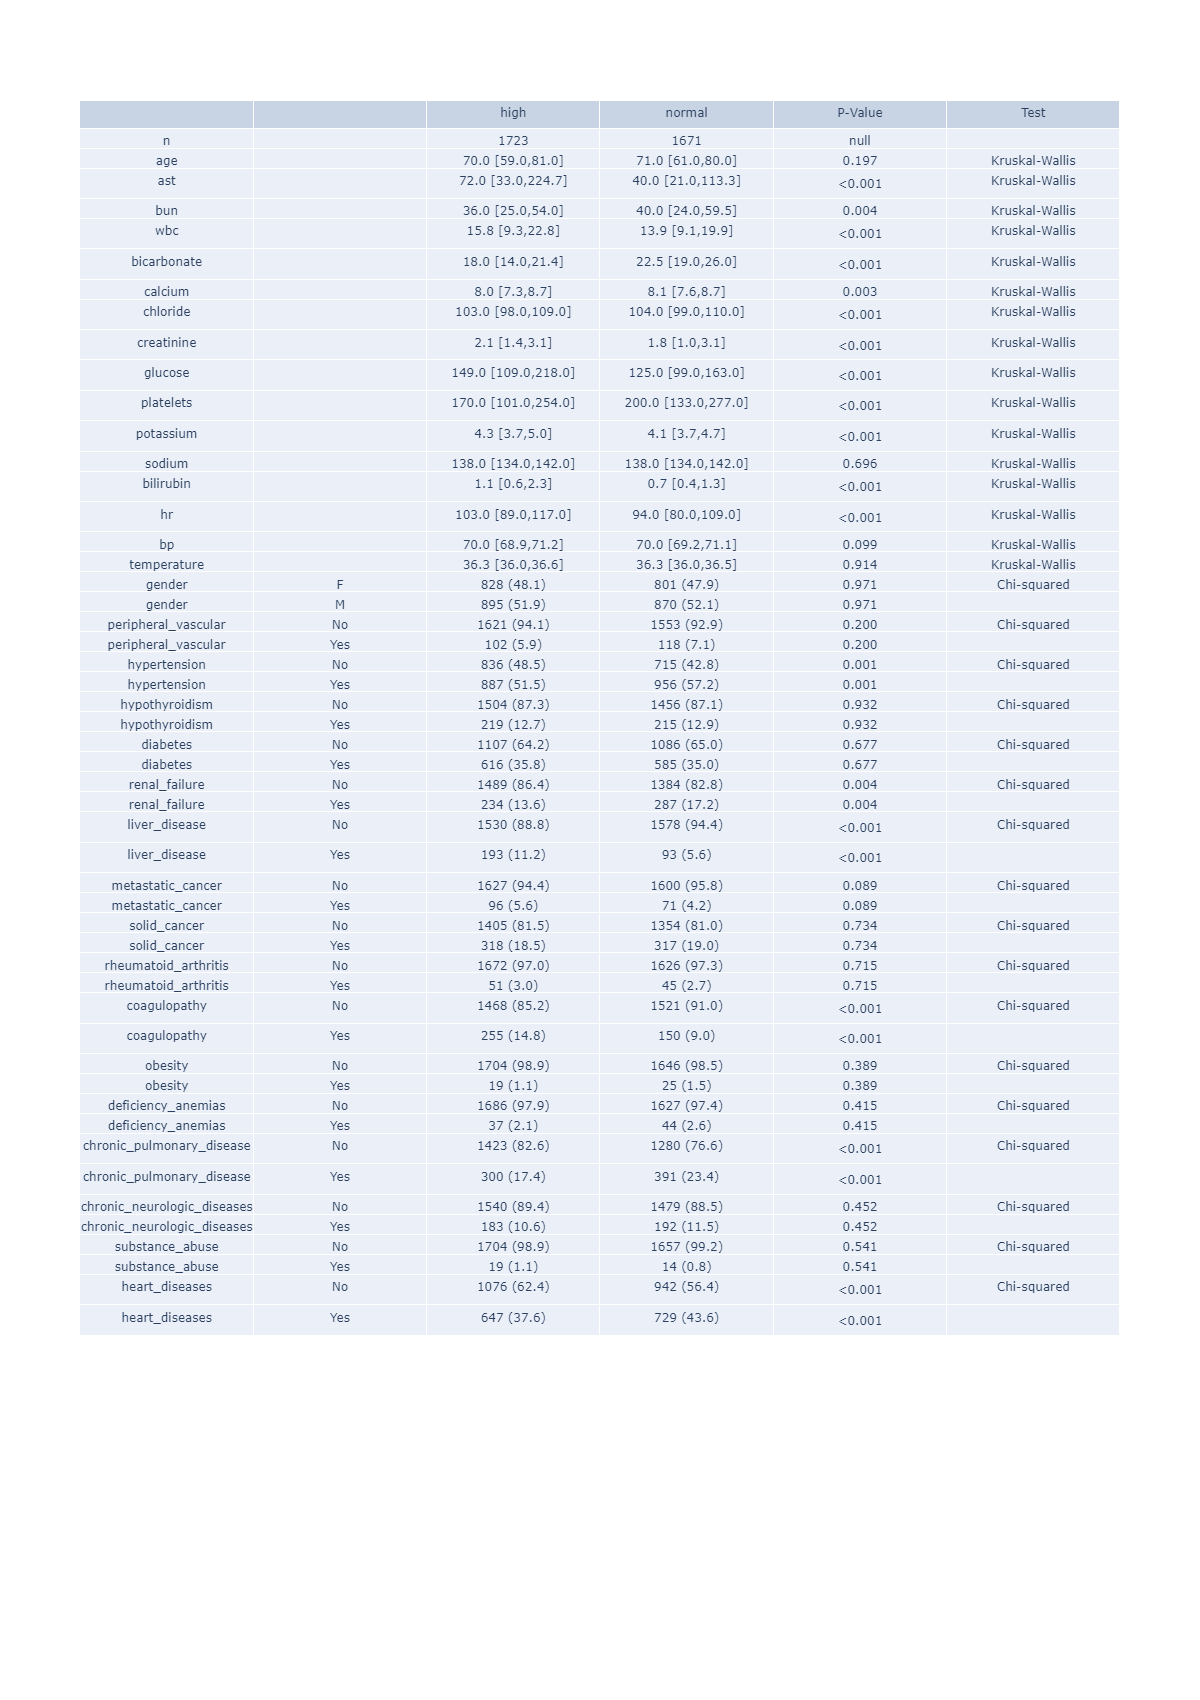

In [80]:
print("--------------------------")

print("Table lactate eicu")
eicu_sel = eicu_no_std.copy()


# TABLEONE para todo menos para ICU_LOS, IMV_d y VFD
# Divido las variables en categoricas y numéricas. 
categorical=list(eicu_sel.columns[eicu_sel.dtypes==np.object].drop('lactate_label'))
nonnormal=list(eicu_sel.columns[eicu_sel.dtypes!=np.object])

# Saco la tableone y formateo
tableOne=TableOne(eicu_sel, nonnormal=nonnormal,categorical=categorical,groupby=['lactate_label'], pval=True)
tableOne=tableOne.tableone.reset_index()
tableOne.columns = [col[0] if col[-1]=='' else col[-1] for col in tableOne.columns.values]
tableOne=tableOne.rename(columns={'level_0':'','level_1':' '})

tableOne.index= tableOne['']

# Elimino la columna de nulos porque no hay
tableOne=tableOne.drop('Missing',axis=1)
tableOne['P-Value'] = np.where(tableOne['P-Value']=='',None,tableOne['P-Value'])
tableOne=tableOne.fillna(method='ffill')
# QuartilesScore=QuartilesScore.drop(columns={'Test'})

tableOne.to_csv('Tables/eicu_lactate.csv', sep=';', header = True, index=False)
# Ploteo la tabla
import plotly.graph_objects as go
fig = go.Figure(data=[go.Table(
    header=dict(values=list(tableOne.columns),
                align='center'),
    cells=dict(values=[tableOne[''],tableOne[' '],tableOne['high'],tableOne['normal'],tableOne['P-Value'],tableOne['Test']],
               align='center'))
])

fig.update_layout(width=1200, height=1700)
fig.write_image("Tables/eicu_table.png")
figura=fig.to_image(format='png')
from IPython.display import Image
display(Image(figura))


# Logistic Regression with CV
***

- eicu

In [81]:
sklearn.__version__

'0.21.3'

In [82]:
print("--------------------------")

print("Logistic Regression at eicu for feature selection")

from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

feature_selector = SequentialFeatureSelector(LogisticRegression(solver='lbfgs'),
           k_features='best',
           scoring='roc_auc',
           forward=True,
           cv=5, n_jobs=-1)

eicu_lr = eicu.copy()
eicu_lr.to_csv('GeneratedFiles/Databases/eicu_lr.csv', sep=';', header = True, index=False)

eicu_lr['gender'] = np.where(eicu_lr['gender']=='M',1,0)


categorical=eicu_lr[list(eicu_lr.columns[eicu_lr.dtypes==np.object])].drop(['lactate_label'],axis=1)
for col in categorical:
    eicu_lr[col] = np.where(eicu_lr[col]=='Yes',1,0)
y = eicu_lr['lactate_label']
x= eicu_lr.drop(['lactate_label'],axis=1)
features = feature_selector.fit(np.array(x), y)


filtered_features= x.columns[list(features.k_feature_idx_)]
print("Selected features")
print(filtered_features)



--------------------------
Logistic Regression at eicu for feature selection
Selected features
Index(['age', 'ast', 'bun', 'wbc', 'bicarbonate', 'calcium', 'chloride',
       'creatinine', 'glucose', 'platelets', 'potassium', 'sodium',
       'bilirubin', 'hr', 'bp', 'gender', 'peripheral_vascular',
       'hypertension', 'liver_disease', 'coagulopathy',
       'chronic_pulmonary_disease', 'heart_diseases'],
      dtype='object')


In [83]:
print(len(filtered_features))
print(features.k_score_)

22
0.853745731798254


In [84]:

filtered_features=filtered_features.to_list()
filtered_features.append('lactate_label')

In [85]:
from sklearn.model_selection import cross_validate
eicu_lr = eicu.copy()

eicu_lr = eicu_lr[filtered_features]
eicu_lr_2 = eicu_lr.copy()

if 'gender' in filtered_features:
    eicu_lr['gender'] = np.where(eicu_lr['gender']=='M',1,0)
    
categorical=eicu_lr[list(eicu_lr.columns[eicu_lr.dtypes==np.object])].drop(['lactate_label'],axis=1)
for col in categorical:
    eicu_lr[col] = np.where(eicu_lr[col]=='Yes',1,0)

eicu_lr['lactate_label'] = np.where(eicu_lr['lactate_label'] == 'high',1,0)

lr = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='ovr', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
y_lr = eicu_lr['lactate_label']
x_lr= eicu_lr.drop(['lactate_label'],axis=1)

cv_model = cross_validate(lr, x_lr, y_lr, cv=5, return_train_score=True, return_estimator=True, scoring = ['accuracy', 'recall', 'roc_auc'])

scores=pd.DataFrame(cv_model['test_accuracy'])
scores.columns=['score']
scores = scores.sort_values('score',ascending=False)
print("Scores of Cross Validation")
print(scores)

best_estimator = cv_model['estimator'][scores.iloc[0].name]

print('roc '+str(cv_model['test_roc_auc'][scores.iloc[0].name]))
print('recall '+str(cv_model['test_recall'][scores.iloc[0].name]))

Scores of Cross Validation
      score
1  0.799705
0  0.785294
2  0.774669
4  0.771386
3  0.749263
roc 0.873600624837282
recall 0.8057971014492754


Importance of features for eicu after CV


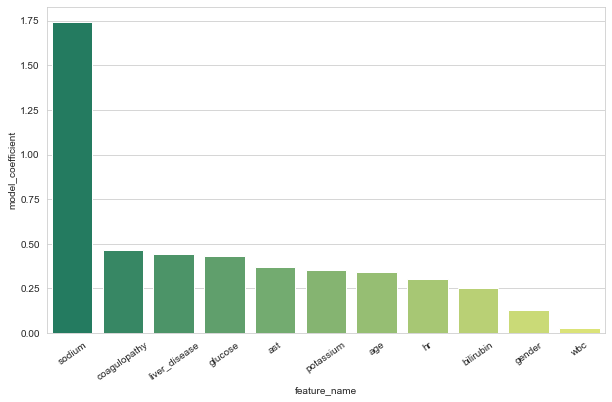

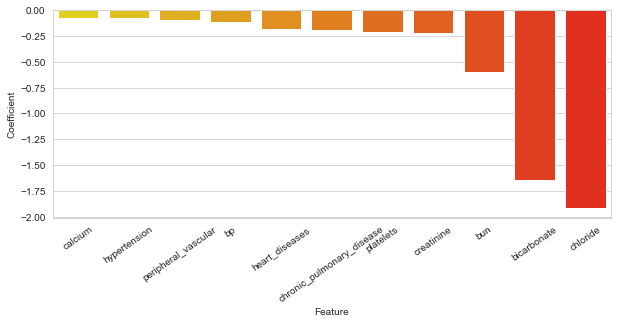

In [86]:
print("Importance of features for eicu after CV") 
# Get the models coefficients (and top 5 and bottom 5)
logReg_coeff_lr_eicu = pd.DataFrame({'feature_name': x_lr.columns.values, 'model_coefficient': best_estimator.coef_.transpose().flatten()})
logReg_coeff_lr_eicu = logReg_coeff_lr_eicu.sort_values('model_coefficient',ascending=False)
logReg_coeff_top = logReg_coeff_lr_eicu.head(sum(logReg_coeff_lr_eicu['model_coefficient']>0))
logReg_coeff_bottom = logReg_coeff_lr_eicu.tail(sum(logReg_coeff_lr_eicu['model_coefficient']<0))


# Plot top 5 coefficients
plt.figure().set_size_inches(10, 6)
fg3 = sb.barplot(x='feature_name', y='model_coefficient',data=logReg_coeff_top, palette="summer")
fg3.set_xticklabels(rotation=35, labels=logReg_coeff_top.feature_name)
# Plot bottom 5 coefficients
plt.figure().set_size_inches(10,6)
fg4 = sb.barplot(x='feature_name', y='model_coefficient',data=logReg_coeff_bottom, palette="autumn_r")
fg4.set_xticklabels(rotation=35, labels=logReg_coeff_bottom.feature_name)
plt.xlabel('Feature')
plt.ylabel('Coefficient')
plt.subplots_adjust(bottom=0.4)
# plt.savefig('figure_4.png')

In [87]:
print("Classification")

from sklearn import metrics
pred=best_estimator.predict(x_lr)
classes_lr=np.where(np.logical_and(pred==1,y_lr.values==1),'TP',
         np.where(np.logical_and(pred==1,y_lr.values==0),'FP',
                  np.where(np.logical_and(pred==0,y_lr.values==0), 'TN',
                           np.where(np.logical_and(pred==0,y_lr.values==1),'FN','MAL'))))
import scipy
print(scipy.stats.itemfreq(classes_lr))


Classification
[['FN' '405']
 ['FP' '333']
 ['TN' '1338']
 ['TP' '1318']]


In [88]:
logReg_coeff_lr_eicu.to_csv('GeneratedFiles/ImportantVariables/coef_lr_eicu.csv', sep=';', header = False, index=False)

# RandomForest with CV
***

- eicu

In [89]:
print("--------------------------")

print("Random Forest at eicu for feature selection")

feature_selector = SequentialFeatureSelector(RandomForestClassifier(n_estimators=200, random_state=0,max_depth=10,  n_jobs=-1),
           k_features='best',
           scoring='roc_auc',
           forward=True,
           cv=5, n_jobs=-1)

eicu_rf = eicu.copy()
eicu_rf_2 = eicu_rf.copy()
eicu_rf_2.to_csv('GeneratedFiles/Databases/eicu_rf.csv', sep=';', header = True, index=False)

eicu_rf_2['gender'] = np.where(eicu_rf_2['gender']=='M',1,0)

categorical=eicu_rf_2[list(eicu_rf_2.columns[eicu_rf_2.dtypes==np.object])].drop(['lactate_label'],axis=1)
for col in categorical:
    eicu_rf_2[col] = np.where(eicu_rf_2[col]=='Yes',1,0)
y = eicu_rf_2['lactate_label']
x= eicu_rf_2.drop(['lactate_label'],axis=1)
features = feature_selector.fit(np.array(x), y)


filtered_features= x.columns[list(features.k_feature_idx_)]
print("Selected Features")
print(filtered_features)


--------------------------
Random Forest at eicu for feature selection
Selected Features
Index(['age', 'ast', 'bun', 'bicarbonate', 'calcium', 'chloride', 'creatinine',
       'glucose', 'potassium', 'sodium', 'bilirubin', 'hr', 'gender',
       'hypothyroidism', 'heart_diseases'],
      dtype='object')


In [90]:
print(len(filtered_features))
print(features.k_score_)

15
0.8296656873536931


In [91]:

filtered_features=filtered_features.to_list()
filtered_features.append('lactate_label')

Score for CV
      score
4  0.774336
1  0.755523
2  0.749632
3  0.743363
0  0.735294
roc 0.8459389360813258
recall 0.7441860465116279


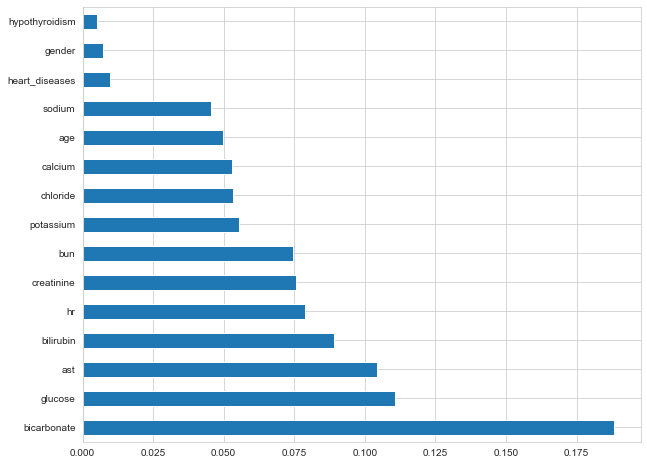

In [92]:
from sklearn.model_selection import cross_validate
eicu_rf_2 = eicu_rf.copy()

eicu_rf_2 = eicu_rf_2[filtered_features]

if 'gender' in filtered_features:
    eicu_rf_2['gender'] = np.where(eicu_rf_2['gender']=='M',1,0)

categorical=eicu_rf_2[list(eicu_rf_2.columns[eicu_rf_2.dtypes==np.object])].drop(['lactate_label'],axis=1)
for col in categorical:
    eicu_rf_2[col] = np.where(eicu_rf_2[col]=='Yes',1,0)

eicu_rf_2['lactate_label'] = np.where(eicu_rf_2['lactate_label'] == 'high',1,0)

rf = features.estimator
y_rf = eicu_rf_2['lactate_label']
x_rf= eicu_rf_2.drop(['lactate_label'],axis=1)


cv_model = cross_validate(rf, x_rf, y_rf, cv=5, return_train_score=True, return_estimator=True, scoring = ['accuracy', 'recall', 'roc_auc'])
scores=pd.DataFrame(cv_model['test_accuracy'])
scores.columns=['score']
scores = scores.sort_values('score',ascending=False)
print("Score for CV")
print(scores)

bestRF = cv_model['estimator'][scores.iloc[0].name]
plt.figure(103)
importances = pd.Series(bestRF.feature_importances_,x_rf.columns)
importances.nlargest(20).plot(kind='barh')

print('roc '+str(cv_model['test_roc_auc'][scores.iloc[0].name]))
print('recall '+str(cv_model['test_recall'][scores.iloc[0].name]))


In [93]:
for var in importances.index:
    if var in list(categorical.columns):
        high = sum(eicu_rf_2.loc[eicu_rf_2['lactate_label']==1][var] == 1)
        low = sum(eicu_rf_2.loc[eicu_rf_2['lactate_label']==0][var] == 1)
        if(high<=low):
            importances[var] = -importances[var]
    else:
        high = np.median(eicu_rf_2.loc[eicu_rf_2['lactate_label']==1][var])
        low = np.median(eicu_rf_2.loc[eicu_rf_2['lactate_label']==0][var])
        if(high<=low):
            importances[var] = -importances[var]

Importance of features for eicu after CV


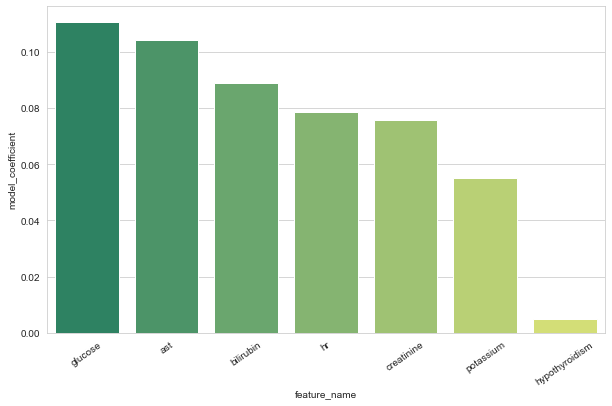

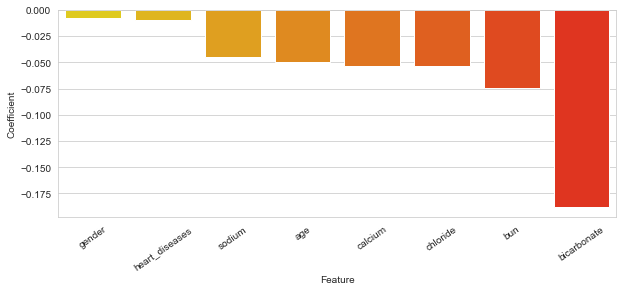

In [94]:
print("Importance of features for eicu after CV") 
    
# Get the models coefficients (and top 5 and bottom 5)
logReg_coeff_rf_eicu = pd.DataFrame({'feature_name': x_rf.columns.values, 'model_coefficient': importances})
logReg_coeff_rf_eicu = logReg_coeff_rf_eicu.sort_values('model_coefficient',ascending=False)
logReg_coeff_top = logReg_coeff_rf_eicu.head(sum(logReg_coeff_rf_eicu['model_coefficient']>0))
logReg_coeff_bottom = logReg_coeff_rf_eicu.tail(sum(logReg_coeff_rf_eicu['model_coefficient']<0))


# Plot top 5 coefficients
plt.figure(100).set_size_inches(10, 6)
fg3 = sb.barplot(x='feature_name', y='model_coefficient',data=logReg_coeff_top, palette="summer")
fg3.set_xticklabels(rotation=35, labels=logReg_coeff_top.feature_name)
# Plot bottom 5 coefficients
plt.figure(101).set_size_inches(10,6)
fg4 = sb.barplot(x='feature_name', y='model_coefficient',data=logReg_coeff_bottom, palette="autumn_r")
fg4.set_xticklabels(rotation=35, labels=logReg_coeff_bottom.feature_name)
plt.xlabel('Feature')
plt.ylabel('Coefficient')
plt.subplots_adjust(bottom=0.4)
# plt.savefig('figure_4.png')

In [95]:
print("Classification")
from sklearn import metrics
pred=bestRF.predict(x_rf)
classes_rf=np.where(np.logical_and(pred==1,y_rf.values==1),'TP',
         np.where(np.logical_and(pred==1,y_rf.values==0),'FP',
                  np.where(np.logical_and(pred==0,y_rf.values==0), 'TN',
                           np.where(np.logical_and(pred==0,y_rf.values==1),'FN','MAL'))))
import scipy
print(scipy.stats.itemfreq(classes_rf))


Classification
[['FN' '207']
 ['FP' '115']
 ['TN' '1556']
 ['TP' '1516']]


In [96]:
logReg_coeff_rf_eicu.to_csv('GeneratedFiles/ImportantVariables/coef_rf_eicu.csv', sep=';', header = False, index=False)


# ORTHOGONAL PLS

In [97]:
print("--------------------------")

print("Orthogonal PLS at eicu for feature selection")

eicu_pls=eicu.copy()
eicu_pls.to_csv('GeneratedFiles/Databases/eicu_pls.csv', sep=';', header = True, index=False)
eicu_pls['gender'] = np.where(eicu_pls['gender']=='M',1,0)
categorical=eicu_pls[list(eicu_pls.columns[eicu_pls.dtypes==np.object])].drop(['lactate_label'],axis=1)
for col in categorical:
    eicu_pls[col] = np.where(eicu_pls[col]=='Yes',1,0)

eicu_pls['lactate_label'] = np.where(eicu_pls['lactate_label'] == 'high',1,0)

y_lr = eicu_pls['lactate_label']
x_lr= eicu_pls.drop(['lactate_label'],axis=1)


# x_lr=x_lr.drop('classes', axis=1)
y_lr = np.array(y_lr, dtype=int)

--------------------------
Orthogonal PLS at eicu for feature selection


In [98]:
import itertools
from sklearn.model_selection import KFold
from pyopls import OPLS
from sklearn.cross_decomposition import PLSCanonical, PLSRegression, CCA
from sklearn import metrics

def primeros_tres_pls():
    combinatoria= list(itertools.combinations(list(x_lr.columns),3))
    mejor_media = 0 
    for i in combinatoria: 
        actual = list()
        for var in i: 
            actual.append(var)
        x_pls = pd.DataFrame(x_lr[actual])
        kf = KFold(n_splits=5)
        roc_pls_componentes=list()
        for train_index, test_index in kf.split(eicu):
            X_train = x_pls.iloc[train_index]
            X_test = x_pls.iloc[test_index]
            y_train, y_test = y_lr[train_index], y_lr[test_index]
            opls = OPLS(2,scale=False)
            Z = opls.fit(X_train, y_train)
            X_train=X_train.astype(np.float64)
            Z_trans= Z.transform(X_train)
            pls2 = PLSRegression(1,scale=False)
            pls2.fit(Z_trans, y_train)
            X_test=X_test.astype(np.float64)
            Z_trans_test = Z.transform(X_test)
            predict=pls2.predict(Z_trans_test)
            predict_roc=np.where(predict>1,1,np.where(predict<0,0,predict))
            roc_pls_componentes.append(metrics.roc_auc_score(y_test,predict_roc))
        roc_pls_componentes.sort(reverse=True)
#         media_acc = roc_pls_componentes[0]
        media_acc = sum(roc_pls_componentes)/5
        if media_acc>mejor_media: 
            mejor_media = media_acc
            selected = actual
    return(mejor_media, selected)

In [99]:
from sklearn.model_selection import KFold
from pyopls import OPLS
from sklearn.cross_decomposition import PLSCanonical, PLSRegression, CCA
from sklearn import metrics

def busca_nueva(dataset,objetivo, media_actual, seleccionadas):
    lista_vars = list(dataset.columns)
    lista_vars=[ele for ele in lista_vars if ele not in selected] 
    mejor_media=media_actual
    mejor_var = ''
    for i in (lista_vars):
        selected.append(i)
        x_pls = pd.DataFrame(dataset[selected])
        kf = KFold(n_splits=5)
        roc_pls_componentes=list()
        for train_index, test_index in kf.split(eicu):
            X_train = x_pls.iloc[train_index]
            X_test = x_pls.iloc[test_index]
            y_train, y_test = objetivo[train_index], objetivo[test_index]
            if(len(X_train.columns)==3):
                opls = OPLS(2,scale=False)
            else: 
                opls = OPLS(3,scale=False)
            Z = opls.fit(X_train, y_train)
            X_train=X_train.astype(np.float64)
            Z_trans= Z.transform(X_train)
            pls2 = PLSRegression(1,scale=False)
            pls2.fit(Z_trans, y_train)
            Z_trans_test = Z.transform(X_test)
            predict=pls2.predict(Z_trans_test)
            predict_roc=np.where(predict>1,1,np.where(predict<0,0,predict))
            roc_pls_componentes.append(metrics.roc_auc_score(y_test,predict_roc))
        roc_pls_componentes.sort(reverse=True)
#         media_acc = roc_pls_componentes[0]
        media_acc = sum(roc_pls_componentes)/5
        if media_acc>=mejor_media: 
            mejor_media = media_acc
            mejor_var = i
        selected.remove(i)
#     print("Accuracy media ",str(mejor_media) )
#     print(mejor_var)
    return(mejor_media,mejor_var)
    

media, selected=primeros_tres_pls()
print(media, selected)
trobat = False
while (not(trobat)):
    media_acc,mejor_var=busca_nueva(x_lr,y_lr, media, selected)
    print(media_acc,mejor_var)
    if(mejor_var==''):
        trobat=True
    else: 
        media = media_acc
        selected.append(mejor_var)
    
print("Selected Features")
print(selected)
    





0.7955569281343899 ['bicarbonate', 'chloride', 'sodium']
0.8165821398178774 bun
0.8235374530285874 glucose
0.8281243276825159 bilirubin
0.8303708793473048 hr
0.8330577600226026 age
0.8372388584439158 potassium
0.8396825069085245 platelets
0.840716241661438 coagulopathy
0.8416432030014604 renal_failure
0.8420279890111704 liver_disease
0.8423998144918288 ast
0.8427523217915713 hypertension
0.8428897264861425 bp
0.8429207260244882 chronic_pulmonary_disease
0.8429896619454109 gender
0.8430026864089232 peripheral_vascular
0.8430026864089232 
Selected Features
['bicarbonate', 'chloride', 'sodium', 'bun', 'glucose', 'bilirubin', 'hr', 'age', 'potassium', 'platelets', 'coagulopathy', 'renal_failure', 'liver_disease', 'ast', 'hypertension', 'bp', 'chronic_pulmonary_disease', 'gender', 'peripheral_vascular']


In [100]:
x_pls = x_lr[selected]
kf = KFold(n_splits=5)
accuracy_pls_componentes=list()
roc_pls_componentes=list()
coefs_componentes = list()
recall_componentes = list()
for train_index, test_index in kf.split(eicu):
    X_train = x_pls.iloc[train_index]
    X_test = x_pls.iloc[test_index]
    y_train, y_test = y_lr[train_index], y_lr[test_index]
    opls = OPLS(3,scale=False)
    Z = opls.fit(X_train, y_train)
    Z_trans= Z.transform(X_train)
    pls2 = PLSRegression(1,scale=False)
    pls2.fit(Z_trans, y_train)
    Z_trans_test = Z.transform(X_test)
    predict=pls2.predict(Z_trans_test)
    predict_auc=np.where(predict>=0.5,1,0)
    predict_roc=np.where(predict>1,1,np.where(predict<0,0,predict))
    accuracy_pls_componentes.append(metrics.accuracy_score(y_test,predict_auc))
    roc_pls_componentes.append(metrics.roc_auc_score(y_test,predict_roc))
    recall_componentes.append(metrics.recall_score(y_test,predict_auc))
    coefs_componentes.append(pls2.coef_)
# print(accuracy_pls_componentes)
# print(roc_pls_componentes)


scores=pd.DataFrame(accuracy_pls_componentes)
scores.columns=['score']
scores = scores.sort_values('score',ascending=False)
print("Score for CV")
print(scores)


print('roc '+str(roc_pls_componentes[scores.iloc[0].name]))
print('recall '+str(recall_componentes[scores.iloc[0].name]))

Score for CV
      score
1  0.784978
4  0.780236
0  0.774669
2  0.754050
3  0.740795
roc 0.8511077171546941
recall 0.7632978723404256


Importance of features for eicu after CV


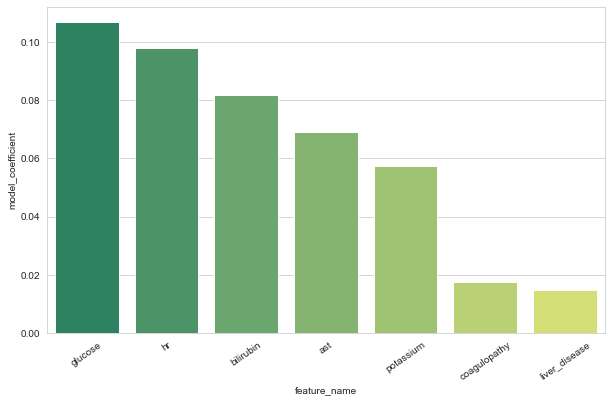

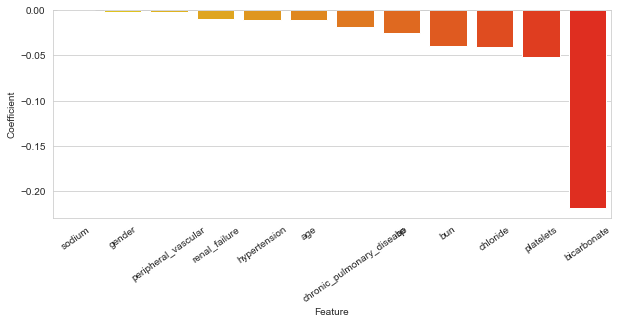

In [101]:
print("Importance of features for eicu after CV") 
feature_importances_ = coefs_componentes[scores.iloc[0].name]
# Get the models coefficients (and top 5 and bottom 5)
logReg_coeff_pls_eicu = pd.DataFrame({'feature_name': x_pls.columns.values, 'model_coefficient': feature_importances_.transpose().flatten()})
logReg_coeff_pls_eicu = logReg_coeff_pls_eicu.sort_values('model_coefficient',ascending=False)
logReg_coeff_top = logReg_coeff_pls_eicu.head(sum(logReg_coeff_pls_eicu['model_coefficient']>0))
logReg_coeff_bottom = logReg_coeff_pls_eicu.tail(sum(logReg_coeff_pls_eicu['model_coefficient']<0))


# Plot top 5 coefficients
plt.figure().set_size_inches(10, 6)
fg3 = sb.barplot(x='feature_name', y='model_coefficient',data=logReg_coeff_top, palette="summer")
fg3.set_xticklabels(rotation=35, labels=logReg_coeff_top.feature_name)
# Plot bottom 5 coefficients
plt.figure().set_size_inches(10,6)
fg4 = sb.barplot(x='feature_name', y='model_coefficient',data=logReg_coeff_bottom, palette="autumn_r")
fg4.set_xticklabels(rotation=35, labels=logReg_coeff_bottom.feature_name)
plt.xlabel('Feature')
plt.ylabel('Coefficient')
plt.subplots_adjust(bottom=0.4)
# plt.savefig('figure_4.png')

In [102]:
logReg_coeff_pls_eicu.to_csv('GeneratedFiles/ImportantVariables/coef_pls_eicu.csv', sep=';', header = False, index=False)